In [1]:
from enum import Enum
from string import ascii_letters
from random import randint, uniform, choice, choices

import os
import json
import threading
import jsonschema
from time import perf_counter

from typing import Literal
from pprint import pprint  # Pretty Print for debugging

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt


SpreadsheetType = Literal["csv", "xlsx", "xls"]

In [2]:
def get_ranges_int(bits: int, unsigned: bool = False) -> tuple[int, int]:
    """Return the range of values for a given bit width."""
    if unsigned:
        return (0, 2**bits - 1)
    return (-(2 ** (bits - 1)), 2 ** (bits - 1) - 1)


def get_ranges_float(bits: int) -> tuple[float, float]:
    """Return the range of values for a given float bit width."""
    if bits == 32:
        return (-3.4028235e38, 3.4028235e38)

    if bits == 64:
        return (-1.7976931348623157e308, 1.7976931348623157e308)

    raise ValueError("Unsupported float bit width.")


datatype_ranges = {
    **{
        f"Int{bits}": {"type": "integer", "range": get_ranges_int(bits, False)}
        for bits in [8, 16, 32, 64, 128]
    },
    **{
        f"UInt{bits}": {"type": "integer", "range": get_ranges_int(bits, True)}
        for bits in [8, 16, 32, 64]
    },
    **{
        f"Float{bits}": {"type": "number", "range": get_ranges_float(bits)}
        for bits in [32, 64]
    },
    "Boolean": {"type": "boolean"},
    "String": {"type": "string"},
}

pprint(datatype_ranges)

{'Boolean': {'type': 'boolean'},
 'Float32': {'range': (-3.4028235e+38, 3.4028235e+38), 'type': 'number'},
 'Float64': {'range': (-1.7976931348623157e+308, 1.7976931348623157e+308),
             'type': 'number'},
 'Int128': {'range': (-170141183460469231731687303715884105728,
                      170141183460469231731687303715884105727),
            'type': 'integer'},
 'Int16': {'range': (-32768, 32767), 'type': 'integer'},
 'Int32': {'range': (-2147483648, 2147483647), 'type': 'integer'},
 'Int64': {'range': (-9223372036854775808, 9223372036854775807),
           'type': 'integer'},
 'Int8': {'range': (-128, 127), 'type': 'integer'},
 'String': {'type': 'string'},
 'UInt16': {'range': (0, 65535), 'type': 'integer'},
 'UInt32': {'range': (0, 4294967295), 'type': 'integer'},
 'UInt64': {'range': (0, 18446744073709551615), 'type': 'integer'},
 'UInt8': {'range': (0, 255), 'type': 'integer'}}


## Generate spreadsheets and its jsonschema for validation

In [4]:
def random_string(length: int = 10) -> str:
    """Generate a random string of fixed length."""
    return "".join(choice(ascii_letters) for _ in range(length))


class DataType(Enum):
    """Enum for data types."""

    # Some data types are commented out for practical purposes.
    Int8 = {
        "name": "Int8",
        "random_data": lambda: randint(*get_ranges_int(8, False)),
        "polars": pl.Int8,
    }
    Int16 = {
        "name": "Int16",
        "random_data": lambda: randint(*get_ranges_int(16, False)),
        "polars": pl.Int16,
    }
    Int32 = {
        "name": "Int32",
        "random_data": lambda: randint(*get_ranges_int(32, False)),
        "polars": pl.Int32,
    }
    # Int64 = {
    #     "name": "Int64",
    #     "random_data": lambda: randint(*get_ranges_int(64, False)),
    #     "polars": pl.Int64,
    # }
    # Int128 = {
    #     "name": "Int128",
    #     "random_data": lambda: randint(*get_ranges_int(128, False)),
    #     "polars": pl.Int128,
    # }
    UInt8 = {
        "name": "UInt8",
        "random_data": lambda: randint(*get_ranges_int(8, True)),
        "polars": pl.UInt8,
    }
    UInt16 = {
        "name": "UInt16",
        "random_data": lambda: randint(*get_ranges_int(16, True)),
        "polars": pl.UInt16,
    }
    UInt32 = {
        "name": "UInt32",
        "random_data": lambda: randint(*get_ranges_int(32, True)),
        "polars": pl.UInt32,
    }
    # UInt64 = {
    #     "name": "UInt64",
    #     "random_data": lambda: randint(*get_ranges_int(64, True)),
    #     "polars": pl.UInt64,
    # }
    Float32 = {
        "name": "Float32",
        "random_data": lambda: uniform(*get_ranges_float(32)),
        "polars": pl.Float32,
    }
    # Float64 = {
    #     "name": "Float64",
    #     "random_data": lambda: uniform(*get_ranges_float(64)),
    #     "polars": pl.Float64,
    # }
    Boolean = {
        "name": "Boolean",
        "random_data": lambda: choice([True, False]),
        "polars": pl.Boolean,
    }
    String = {
        "name": "String",
        "random_data": lambda: random_string(randint(1, 20)),
        "polars": pl.String,
    }

In [ ]:
def generate_jsonschema(df: pl.DataFrame) -> dict:
    """
    Generates a JSON schema with the specified number of rows and columns.
    Each column will have a unique name and type 'integer'.
    """
    properties = {}
    for col, dtype in df.schema.items():
        dtype_str = str(dtype)
        if dtype_str not in datatype_ranges:
            print(f"Unsupported data type: {dtype_str}")
            continue

        dtype_info = datatype_ranges[dtype_str]
        properties[col] = {"type": dtype_info["type"]}
        if "range" in dtype_info:
            properties[col]["minimum"] = dtype_info["range"][0]
            properties[col]["maximum"] = dtype_info["range"][1]

    schema = {
        "$schema": "http://json-schema.org/draft-07/schema#",
        "type": "object",
        "properties": properties,
        "required": list(properties.keys()),
        "additionalProperties": False,
    }

    return schema


def generate_spreadsheet(
    rows: int, columns: int, path: str = "./data", format: SpreadsheetType = "xlsx"
) -> bool:
    """
    Generates a CSV file with the specified number of rows and columns.
    Each column will have a unique name and random integer values.
    """

    def generate_data(dtype: DataType, size: int) -> list:
        """Generate a list of random data based on the DataType."""
        return [dtype.value["random_data"]() for _ in range(size)]

    dtype_options = list(DataType)
    options = choices(dtype_options, k=columns)
    data = {
        f"col_{i}-{opt.value['name']}": pl.Series(generate_data(opt, size=rows))
        for i, opt in enumerate(options)
    }

    df = pl.DataFrame(data)

    # Save the DataFrame to a CSV file
    try:
        if format == "csv":
            df.write_csv(f"{path}/data_rows-{rows}_columns-{columns}.{format}")

        if format in ["xlsx", "xls"]:
            # Polars with floats numbers is horrible, export numbers like 1.1,3
            df.to_pandas().to_excel(
                f"{path}/data_rows-{rows}_columns-{columns}.{format}"
            )
    except Exception as e:
        print(f"Failed to save the file in {format} format. -> {repr(e)}")
        return False

    # Save the JSON schema
    schema = generate_jsonschema(df)
    with open(f"{path}/schema_rows-{rows}_columns-{columns}.json", "w") as f:
        f.write(json.dumps(schema, indent=2))

    return True

In [8]:
# Generate csvs with fixed number of rows and varying columns
rows_fixed = 1000
path_rows = os.path.join("data", "excel", f"rows-{rows_fixed}")
os.makedirs(path_rows, exist_ok=True)

for i in range(100, 1001, 100):
    generate_spreadsheet(rows_fixed, i, path=path_rows, format="xlsx")

In [9]:
# Generate csvs with fixed number of columns and varying rows
columns_fixed = 100
path_columns = os.path.join("data", "excel", f"columns-{columns_fixed}")
os.makedirs(path_columns, exist_ok=True)
for i in range(1000, 10001, 1000):
    generate_spreadsheet(i, columns_fixed, path=path_columns, format="xlsx")

## Plot results

Measure time of execution

In [3]:
def validate_spreadsheet(path: str, n_workers: int = 4) -> pl.DataFrame:
    # Load the spreadsheet file and its schema
    format = os.path.splitext(path)[-1].lower()
    if format == ".csv":
        df = pl.read_csv(path)

    if format in [".xlsx", ".xls"]:
        df = pl.read_excel(path, engine="openpyxl")

    schema_path = (
        os.path.basename(path).replace(format, ".json").replace("data", "schema")
    )
    schema_path = os.path.join(os.path.dirname(path), schema_path)
    with open(schema_path, "r") as f:
        schema = json.load(f)

    # Chunkiy
    chunk_size = len(df) // n_workers
    chunks = [df[i : i + chunk_size] for i in range(0, len(df), chunk_size)]

    # Start threads to validate each chunk
    threads = []
    for chunk in chunks:
        thread = threading.Thread(
            target=validate_chunks, args=(chunk.to_dicts(), schema)
        )
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return df


def validate_chunks(data: list[dict], schema: dict) -> bool:
    for item in data:
        try:
            jsonschema.validate(instance=item, schema=schema)
        except Exception as e:
            print(f"Validation error: {repr(e)} - {item}")


def plot_results(
    data_time: list[tuple[int, float]],
    rows: dict[str, str],  # {"x": "columns", "y": "time"}
    *,
    title: str,
    xlabel: str,
    ylabel: str,
    savefig_path: str,
) -> None:
    """
    Plot the results using seaborn and matplotlib.
    """
    df = pl.DataFrame(data_time, schema=[rows["x"], rows["y"]], orient="row")
    df = df.sort(rows["x"])

    # Create the bar plot
    ax = sns.barplot(data=df, **rows)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add text annotations for each bar
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()

        # Add text annotation
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
            height + 0.5,  # y position (just above bar)
            f"{height:.1f}s",  # text (formatted time)
            ha="center",  # horizontal alignment
            va="bottom",  # vertical alignment
            fontsize=9,  # font size
        )

    plt.tight_layout()
    os.makedirs(os.path.dirname(savefig_path), exist_ok=True)
    plt.savefig(savefig_path)
    plt.show()

In [4]:
formats: dict[SpreadsheetType, dict[str, str]] = {
    "csv": {"folder": "csv"},
    "xlsx": {"folder": "excel"},
    "xls": {"folder": "excel"},
}

### Fixed rows

In [22]:
spreadsheet_type = "xlsx"  # Change to "csv" or "xlsx" as needed
iterations = 20
rows_fixed = 1000
num_workers_rows = 1

In [ ]:
path_rows = os.path.join(
    "data", formats[spreadsheet_type]["folder"], f"rows-{rows_fixed}"
)
spreadsheets = os.listdir(path_rows)
results_rows = []

for i in range(iterations):
    data_time_rows: list[tuple[int, float]] = []
    print(f"Iteration {i + 1}/{iterations} for {spreadsheet_type} spreadsheets...")
    for spreadsheet in spreadsheets:
        if not spreadsheet.endswith(f".{spreadsheet_type}"):
            continue

        print(f"  [+] Validating {spreadsheet}...", end=" ")
        file_path = os.path.join(path_rows, spreadsheet)
        start_time = perf_counter()
        df = validate_spreadsheet(file_path, num_workers_rows)
        total_time = perf_counter() - start_time
        data_time_rows.append((df.shape[1], total_time))
        print(f"Done in {total_time:.2f} seconds.")
    results_rows.append(data_time_rows)

Iteration 1/20 for xlsx spreadsheets...
  [+] Validating data_rows-1000_columns-700.xlsx... Done in 34.59 seconds.
  [+] Validating data_rows-1000_columns-100.xlsx... Done in 4.41 seconds.
  [+] Validating data_rows-1000_columns-1000.xlsx... Done in 44.79 seconds.
  [+] Validating data_rows-1000_columns-400.xlsx... Done in 17.91 seconds.
  [+] Validating data_rows-1000_columns-500.xlsx... Done in 22.21 seconds.
  [+] Validating data_rows-1000_columns-300.xlsx... Done in 13.53 seconds.
  [+] Validating data_rows-1000_columns-900.xlsx... Done in 40.14 seconds.
  [+] Validating data_rows-1000_columns-600.xlsx... Done in 27.13 seconds.
  [+] Validating data_rows-1000_columns-800.xlsx... Done in 35.69 seconds.
  [+] Validating data_rows-1000_columns-200.xlsx... Done in 9.19 seconds.
Iteration 2/20 for xlsx spreadsheets...
  [+] Validating data_rows-1000_columns-700.xlsx... Done in 31.65 seconds.
  [+] Validating data_rows-1000_columns-100.xlsx... Done in 4.75 seconds.
  [+] Validating data_

[(100, 4.490396966200206),
 (200, 9.205352221000794),
 (300, 13.736875489799786),
 (400, 18.31934780665033),
 (500, 22.49665748049956),
 (600, 27.22136882985069),
 (700, 31.772001944050135),
 (800, 36.10668170439967),
 (900, 40.59840883980068),
 (1000, 45.03066017390047)]


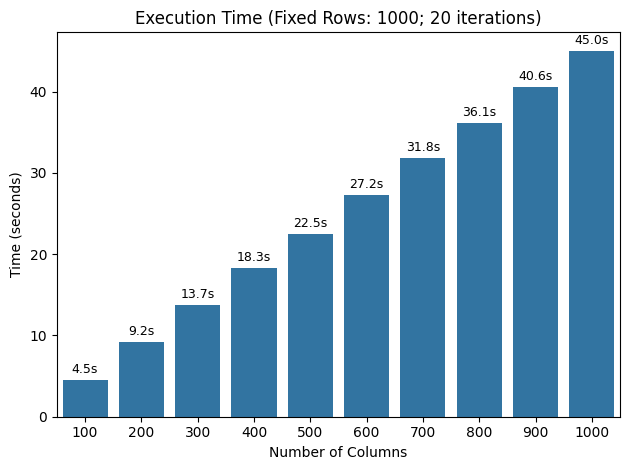

In [ ]:
# Calculate the mean time for each number of columns across all iterations
results_rows = np.array(results_rows)
data_time_rows = results_rows.mean(axis=0).tolist()
data_time_rows = list(map(lambda x: (int(x[0]), float(x[1])), data_time_rows))
pprint(sorted(data_time_rows, key=lambda x: x[0]))

plot_results(
    data_time_rows,
    {"x": "columns", "y": "time"},
    title=f"Execution Time (Fixed Rows: {rows_fixed}; {iterations} iterations)",
    xlabel="Number of Columns",
    ylabel="Time (seconds)",
    savefig_path=f"figures/{formats[spreadsheet_type]['folder']}/rows-{rows_fixed}_num_workers-{num_workers_rows}_iteration-{iterations}.pdf",
)

### Fixed columns

In [7]:
spreadsheet_type = "xlsx"
iterations = 20
columns_fixed = 100
num_workers_columns = 1

In [ ]:
path_columns = os.path.join(
    "data", formats[spreadsheet_type]["folder"], f"columns-{columns_fixed}"
)
spreadsheets = os.listdir(path_columns)

results_columns = []
for i in range(iterations):
    data_time_columns: list[tuple[int, float]] = []
    print(f"Iteration {i + 1}/{iterations} for {spreadsheet_type} spreadsheets...")
    for spreadsheet in spreadsheets:
        if not spreadsheet.endswith(f".{spreadsheet_type}"):
            continue

        print(f"  [+]Validating {spreadsheet}...", end=" ")
        file_path = os.path.join(path_columns, spreadsheet)
        start_time = perf_counter()
        df = validate_spreadsheet(file_path, num_workers_columns)
        total_time = perf_counter() - start_time
        data_time_columns.append((df.shape[0], total_time))
        print(f"Done in {total_time:.2f} seconds.")
    results_columns.append(data_time_columns)

Iteration 1/20 for xlsx spreadsheets...
  [+]Validating data_rows-4000_columns-100.xlsx... Done in 19.19 seconds.
  [+]Validating data_rows-3000_columns-100.xlsx... Done in 14.14 seconds.
  [+]Validating data_rows-1000_columns-100.xlsx... Done in 4.88 seconds.
  [+]Validating data_rows-6000_columns-100.xlsx... Done in 27.88 seconds.
  [+]Validating data_rows-5000_columns-100.xlsx... Done in 23.52 seconds.
  [+]Validating data_rows-7000_columns-100.xlsx... Done in 32.66 seconds.
  [+]Validating data_rows-8000_columns-100.xlsx... Done in 37.34 seconds.
  [+]Validating data_rows-2000_columns-100.xlsx... Done in 9.79 seconds.
  [+]Validating data_rows-10000_columns-100.xlsx... Done in 46.79 seconds.
  [+]Validating data_rows-9000_columns-100.xlsx... Done in 41.73 seconds.
Iteration 2/20 for xlsx spreadsheets...
  [+]Validating data_rows-4000_columns-100.xlsx... Done in 19.24 seconds.
  [+]Validating data_rows-3000_columns-100.xlsx... Done in 14.35 seconds.
  [+]Validating data_rows-1000_co

[(1000, 4.799639691550328),
 (2000, 9.697943088699684),
 (3000, 14.183558951698434),
 (4000, 19.12247746439825),
 (5000, 23.44626096900065),
 (6000, 27.63886689770079),
 (7000, 32.523690300650195),
 (8000, 37.42604521385001),
 (9000, 42.181774233500256),
 (10000, 46.20982733854871)]


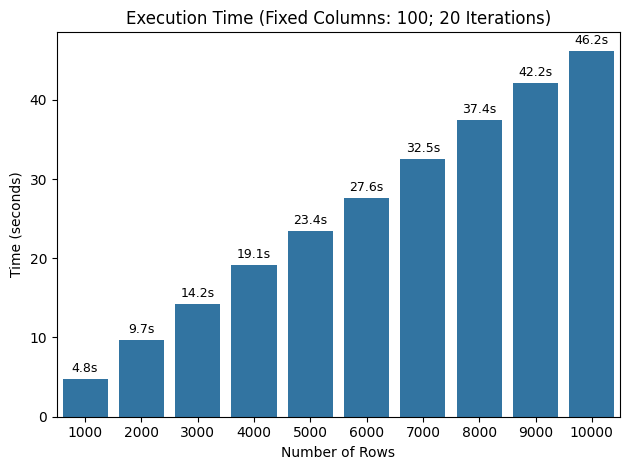

In [ ]:
results_columns = np.array(results_columns)
data_time_columns = results_columns.mean(axis=0).tolist()
data_time_columns = list(map(lambda x: (int(x[0]), float(x[1])), data_time_columns))
pprint(sorted(data_time_columns, key=lambda x: x[0]))

plot_results(
    data_time_columns,
    {"x": "rows", "y": "time"},
    title=f"Execution Time (Fixed Columns: {columns_fixed}; {iterations} Iterations)",
    xlabel="Number of Rows",
    ylabel="Time (seconds)",
    savefig_path=f"figures/{formats[spreadsheet_type]['folder']}/columns-{columns_fixed}_num_workers-{num_workers_columns}_iterations-{iterations}.pdf",
)